In [ ]:
import $ivy.`org.proml::proml-core:0.1.0`
import proml._
import $ivy.`com.cibo::evilplot-jupyter-scala:0.6.1-SNAPSHOT`
import $ivy.`com.cibo::evilplot-repl:0.6.1-SNAPSHOT`
import com.cibo.evilplot._
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.numeric.Point
import almond.interpreter.api._
import almond.api.helpers.Display.Image
import proml.Model
import proml.distributions.Continuous._
import proml.samplers.MetropolisHastings
import com.cibo.evilplot.geometry.Drawable

val trueA = 2d
val trueB = -2d

val points: Seq[(Double, Double)] = for {
  x     <- -10d to 10d by 0.1
  noise  = normal[Double](0, 1).get
} yield (x * 1.0, trueA * x + trueB + noise)


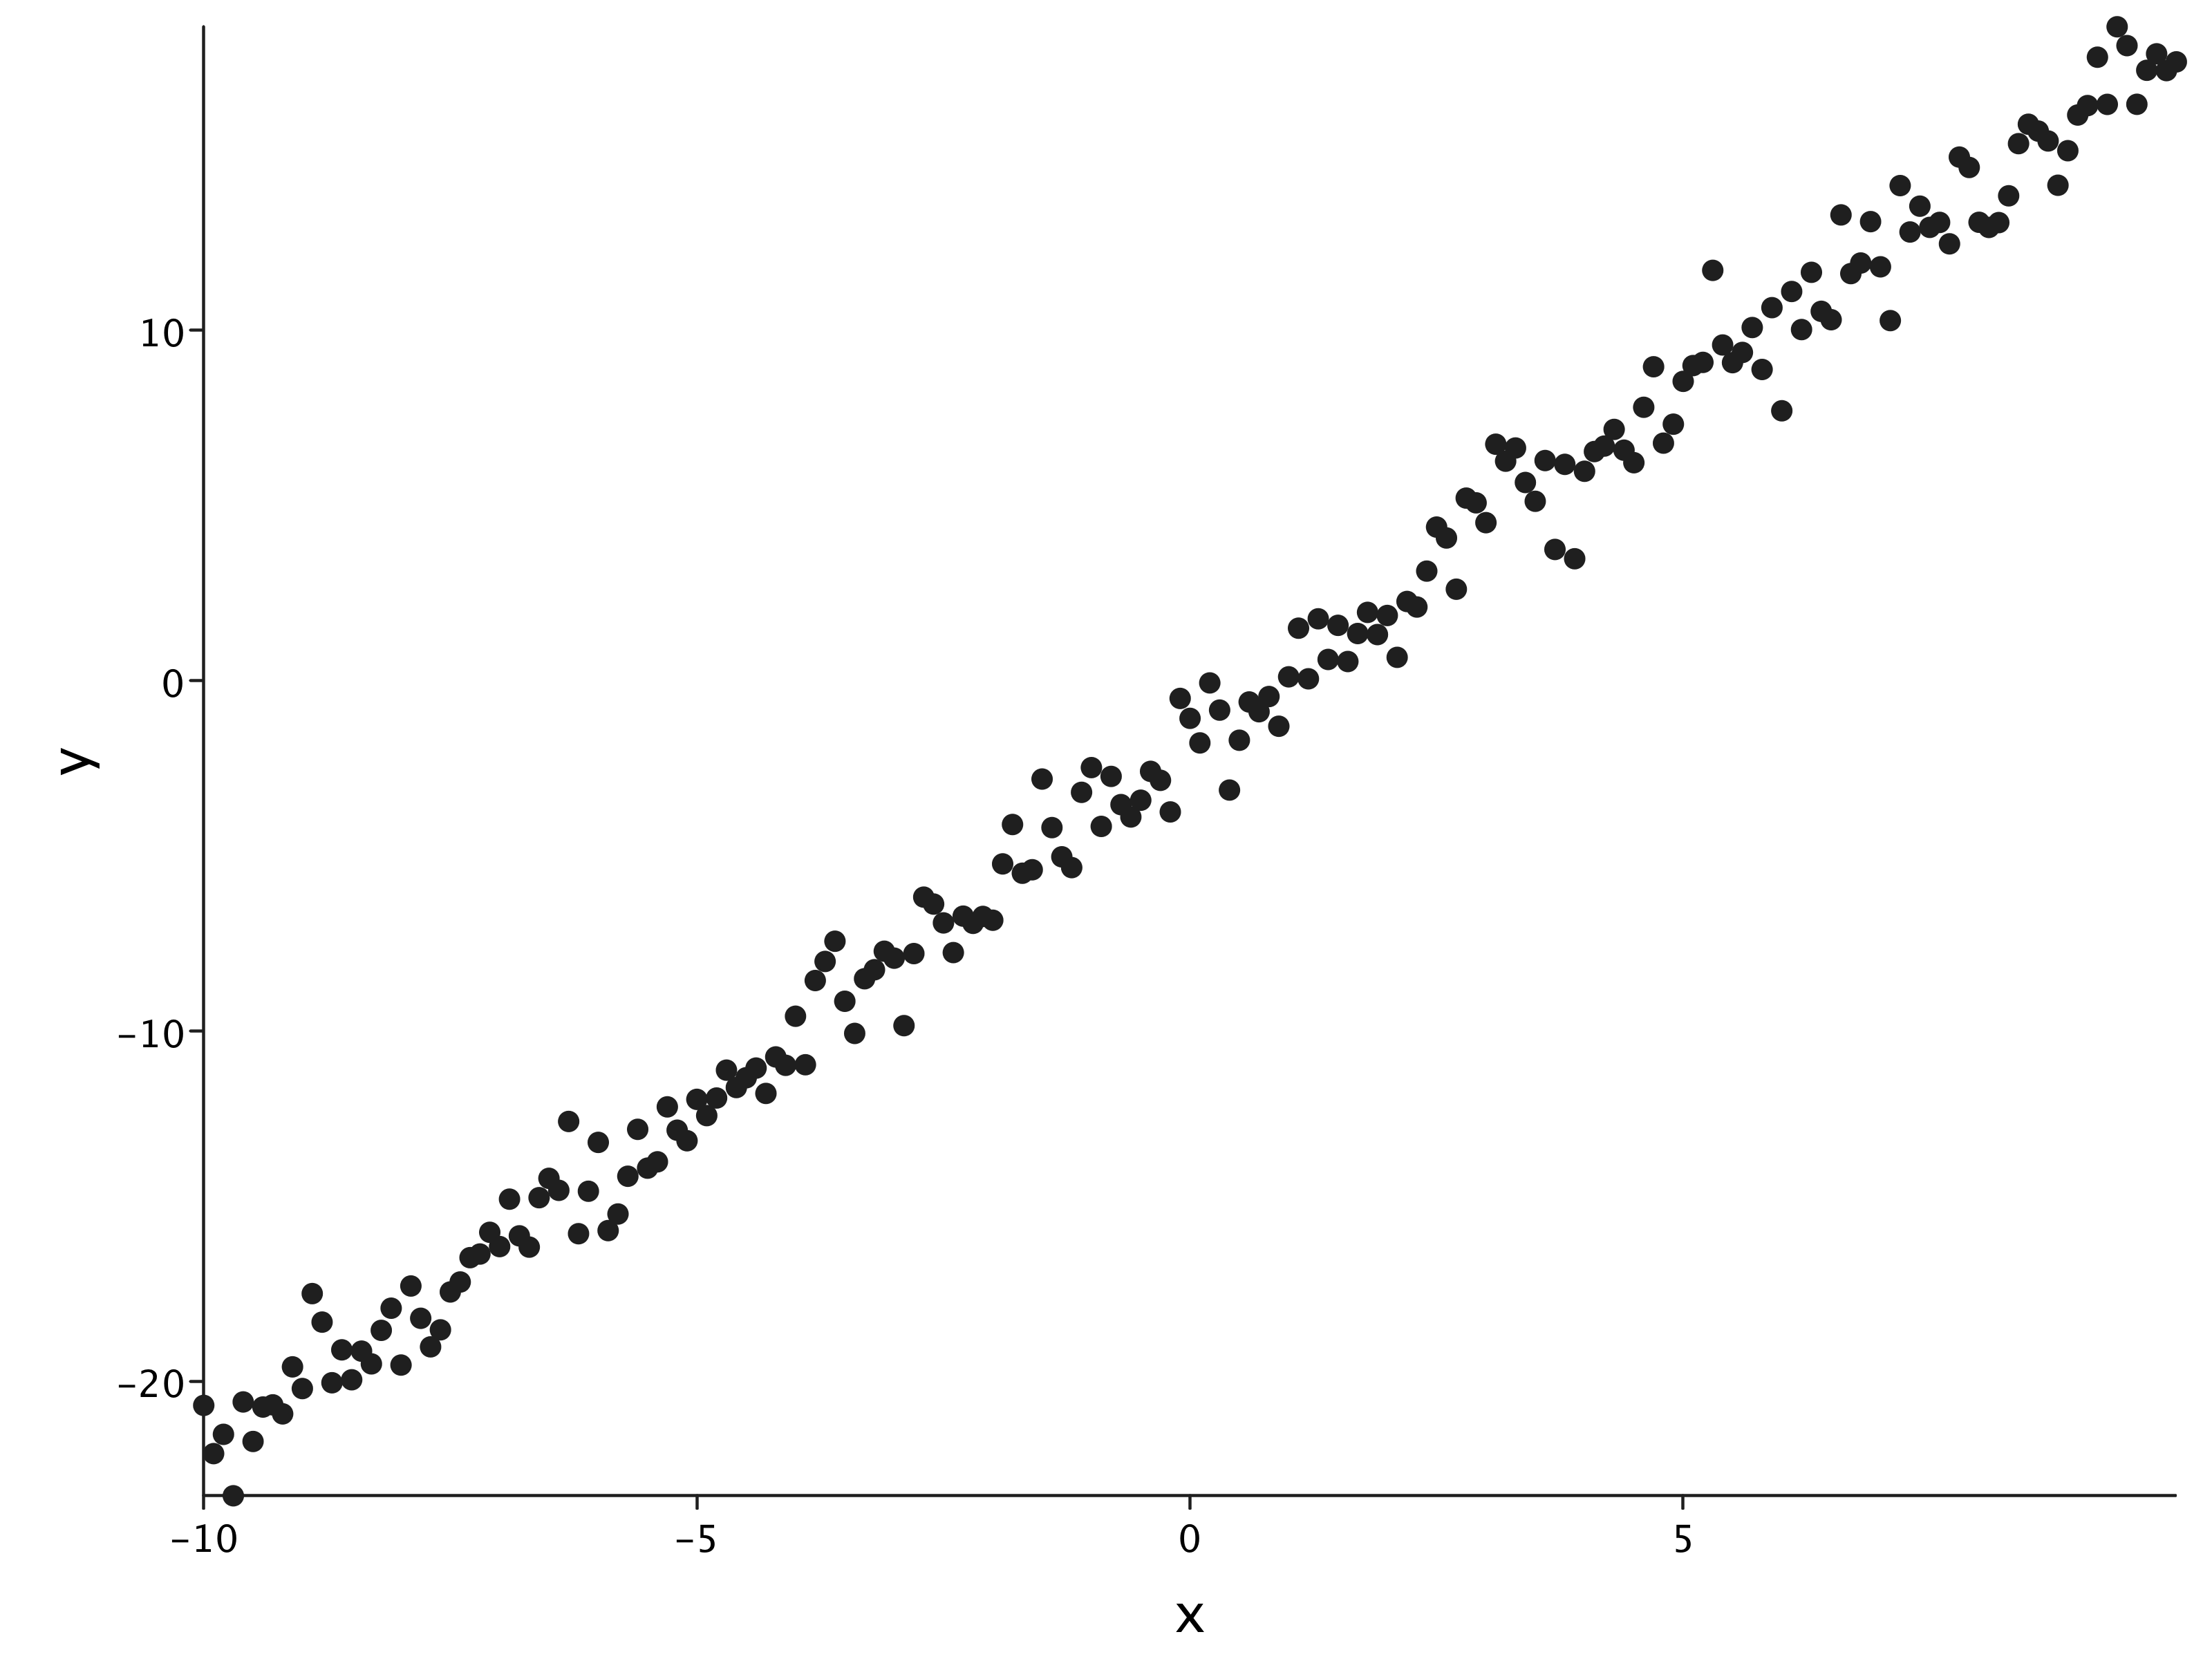

defined function plot
defined function show

In [3]:
def plot(data: Seq[(Double, Double)]) = {
ScatterPlot(
  data.map{p => Point(p._1, p._2)}
).frame()
  .xLabel("x")
  .yLabel("y")
  .frame()
  .xbounds(data.map{_._1}.min, data.map{_._1}.max)
  .ybounds(data.map{_._2}.min, data.map{_._2}.max)
  .xAxis()
  .yAxis()
  .render()
}

def show(drawable: Drawable) {
    import java.io.ByteArrayOutputStream
    import javax.imageio.ImageIO
    val baos = new ByteArrayOutputStream()
    ImageIO.write(drawable.asBufferedImage, "png", baos)
    try{Image.fromArray(baos.toByteArray(), Image.PNG)}
    catch{
      case e: Exception =>  
    }
}

show(plot(points))

In [ ]:
  case class Params(amu: Double, bmu: Double)

  // Blindly assuming, 100 is the slope and -10 is the y-intercept
  val priorAssumption = Params(100, -10)

  def getLogLikelihood(p: Params): Double = {
    normal[Double](priorAssumption.amu, 1).logPdf(p.amu) +
    normal[Double](priorAssumption.bmu, 1).logPdf(p.bmu)
  }

  def getProposal(prior: Params) =
    for {
      a <- normal[Double](0, 1)
      b <- normal[Double](0, 1)
    } yield Params(a + prior.amu, b + prior.bmu)

  val linearModel = new Model[Params, Double, Double] {
    // MCMC proposal to do random walk
    override def proposal = (p: Params) => getProposal(p).get 
    // P(x|θ) 
    override def logPrior = getLogLikelihood 
    // P(θ)  
    override def prior    = priorAssumption
    // y = ax + b    
    override def model    = (p: Params) => (x: Double) => x * p.amu + p.bmu 
  }
  val (best, samples) = linearModel.fit(
      points, 
      MetropolisHastings(20000, 15000)  // MCMC Sampler
  )
  println(best)


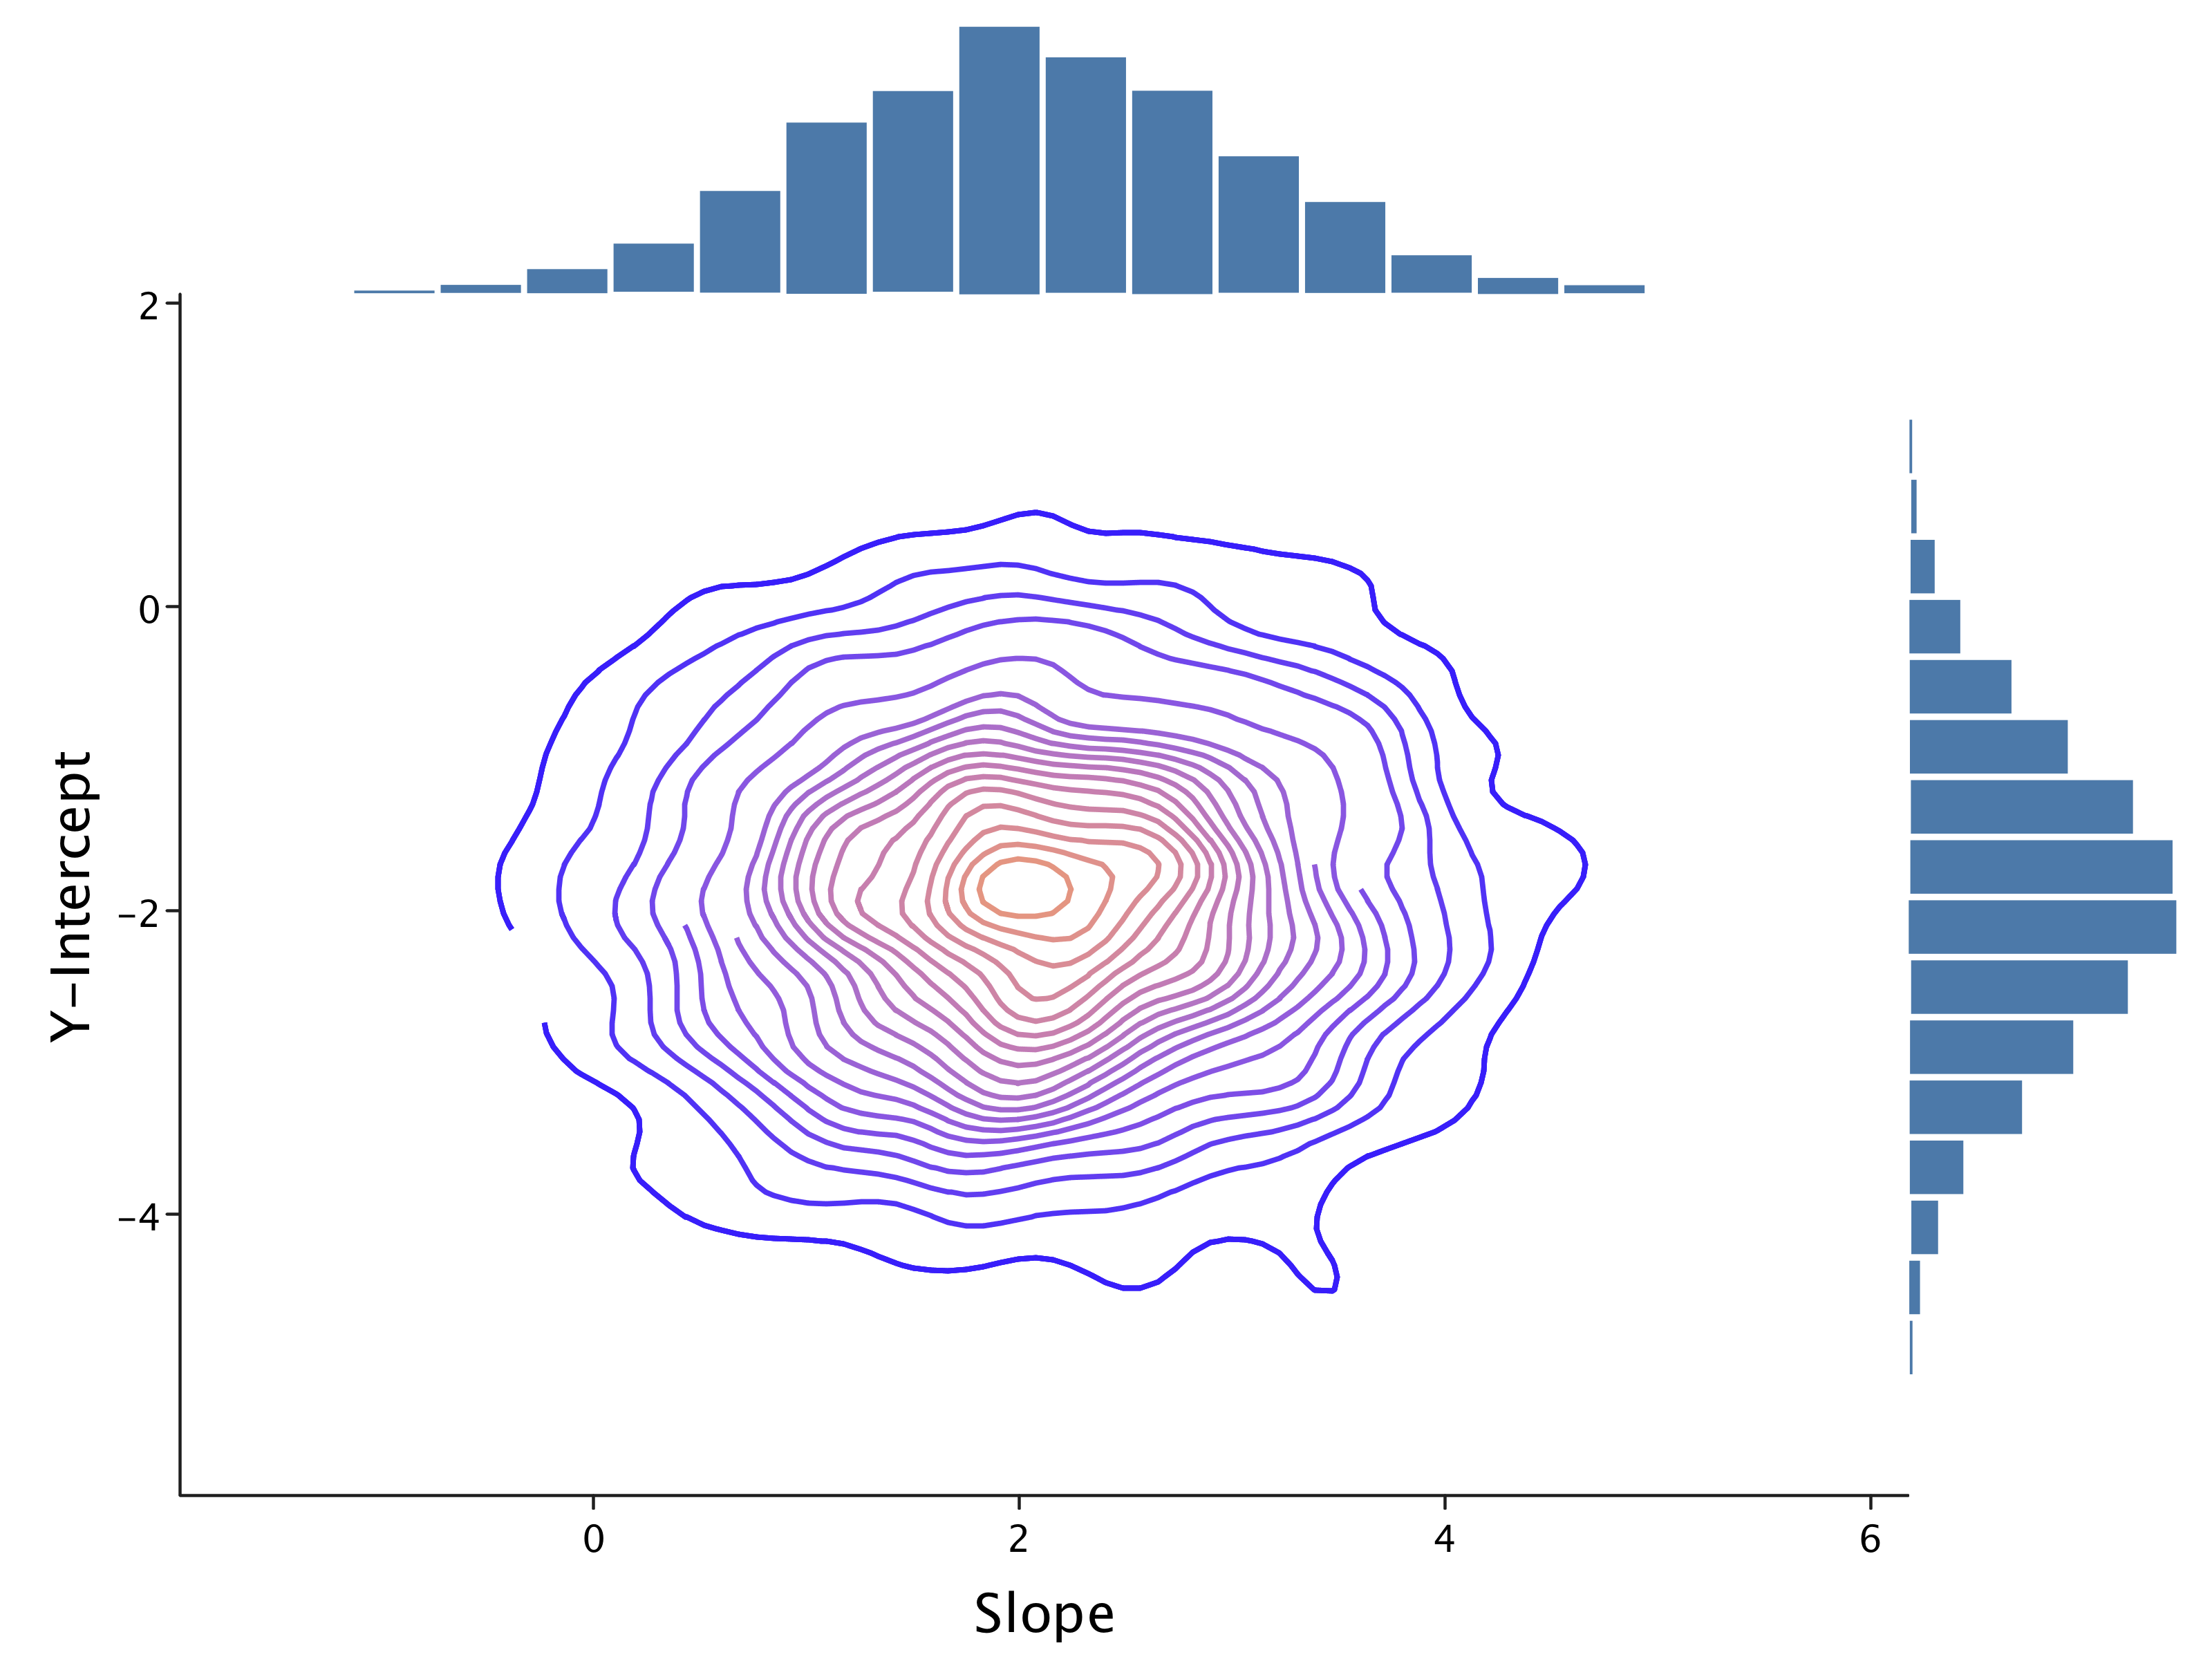

defined function cplot

In [5]:
def cplot(data: Seq[(Double, Double)]) = {
   ContourPlot(
      data.map{p => Point(p._1, p._2)}
    ).frame()
      .xLabel("Slope")
      .yLabel("Y-Intercept")
      .xbounds(data.map{_._1}.min, data.map{_._1}.max)
      .ybounds(data.map{_._2}.min, data.map{_._2}.max)
      .xAxis()
      .yAxis()
      .topPlot(Histogram(data.map{_._1}), 100)
      .rightPlot(Histogram(data.map{_._2}), 100)
      .render()
}

show(cplot(samples.map(s => (s.amu, s.bmu))))